In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_provider import IBMProvider

C:\Users\azadp\AppData\Local\Temp\ipykernel_57712\1329459531.py:7: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [12]:
api_token='IBM TOKEN'

IBMProvider.save_account(api_token, overwrite=True)
provider = IBMProvider()
print("Available backends:", provider.backends())

Available backends: [<IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_brisbane')>]


In [13]:
def qft_rotations(circuit,n):
    if n==0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit),qubit,n)
    qft_rotations(circuit,n)

In [14]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit



In [17]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

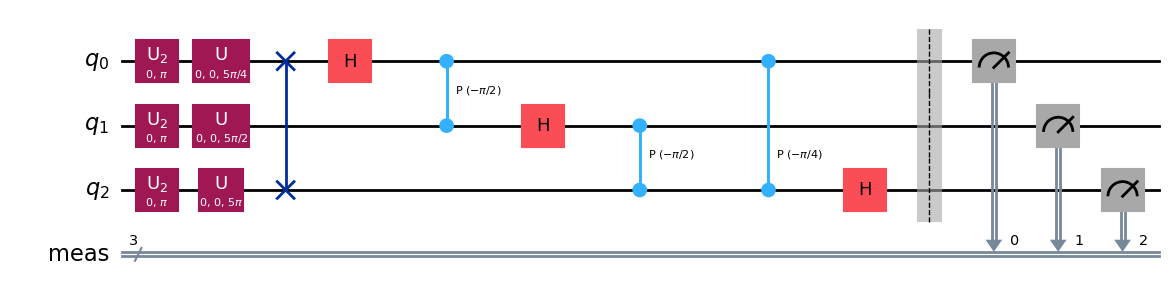

In [22]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw(output="mpl")

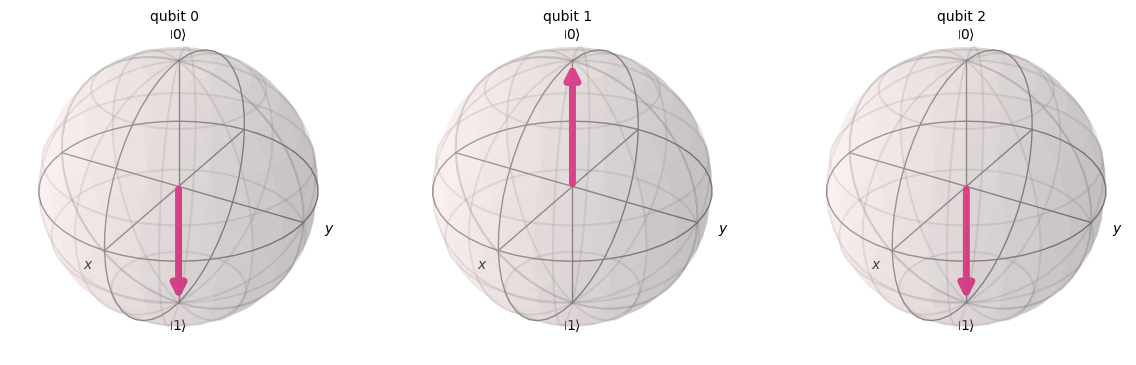

In [23]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [27]:
backends = provider.backends(filters=lambda b: b.status().operational and not b.configuration().simulator)
least_busy_backend = min(backends, key=lambda b: b.status().pending_jobs)


In [32]:
shots = 2048
transpiled_qc = transpile(qc, least_busy_backend, optimization_level=3)
job = least_busy_backend.run(transpiled_qc, shots=shots)

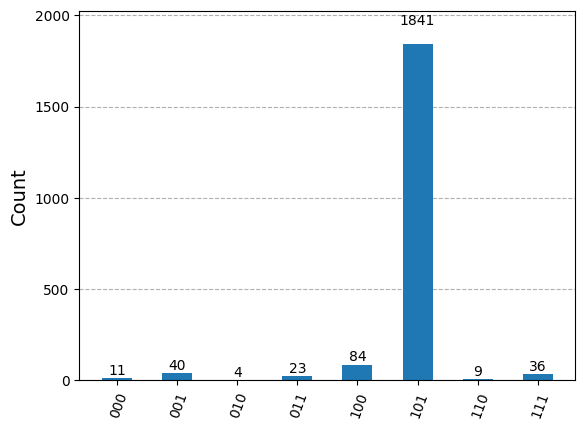

In [33]:
counts = job.result().get_counts()
plot_histogram(counts)